# set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels


import pickle

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

In [3]:
Device = 'cpu'

# Data

In [4]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


# L.MGP

In [5]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=500)

In [11]:
MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=10, device=Device,disable_progbar=False)

 26%|██▌       | 1278/5000 [02:39<07:43,  8.03it/s, loss=-2.23]


In [12]:
MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(
    local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
    covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=50, device=Device,disable_progbar=False)

 51%|█████     | 2526/5000 [05:09<05:03,  8.15it/s, loss=-2.24] 


# Likelihood of L.MGP

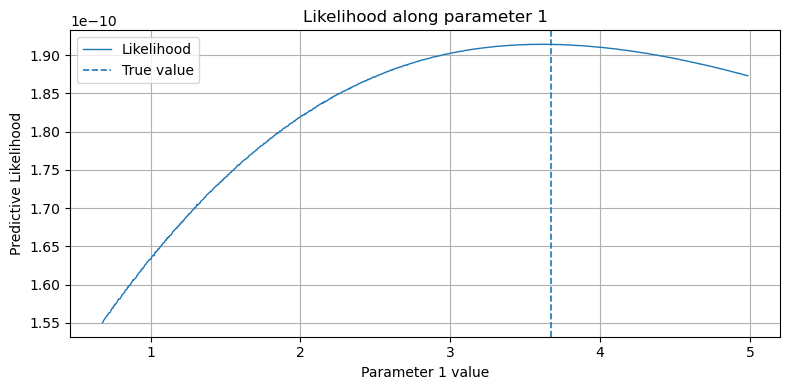

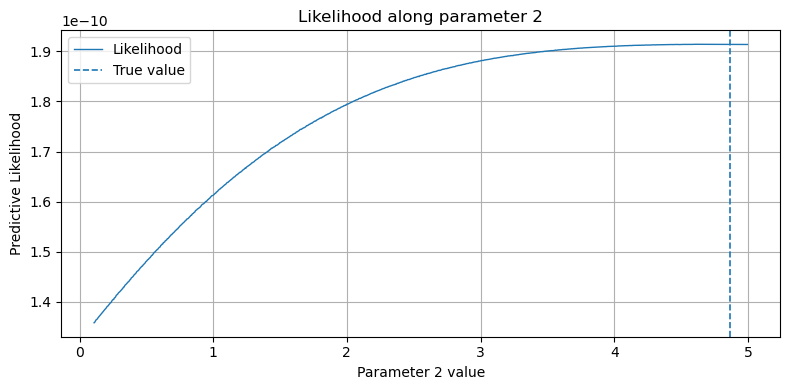

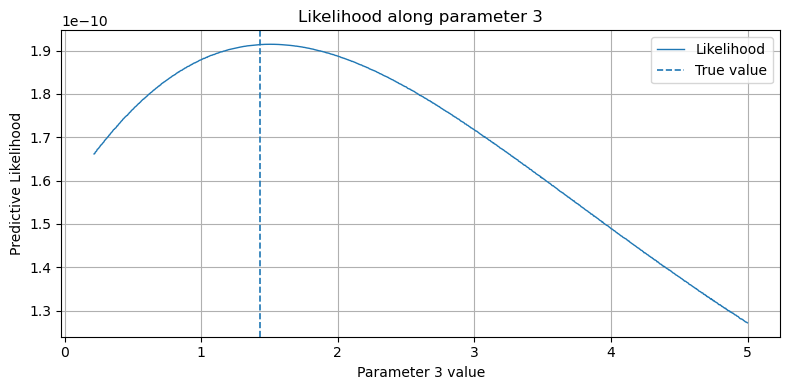

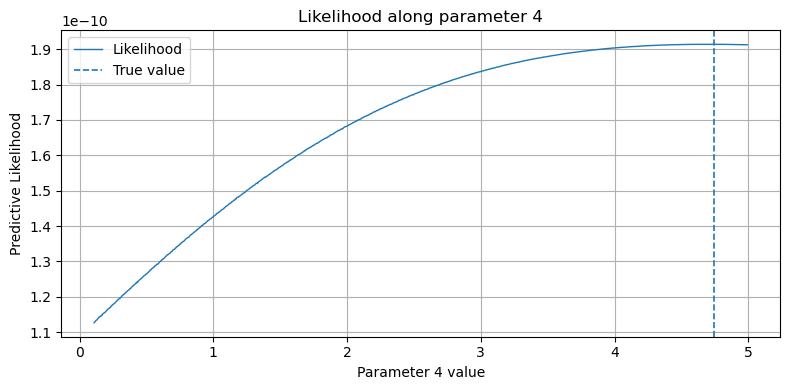

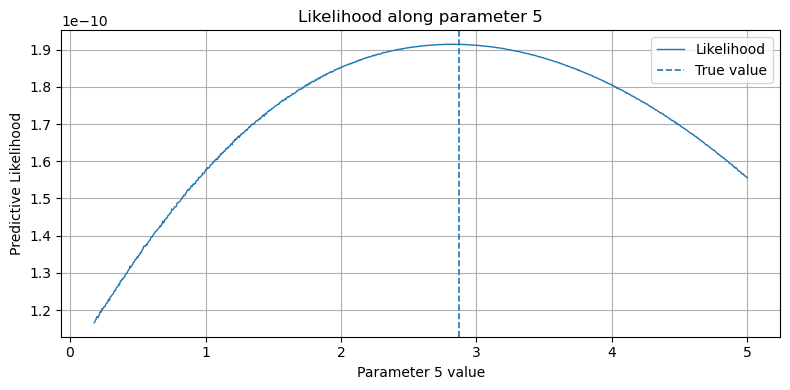

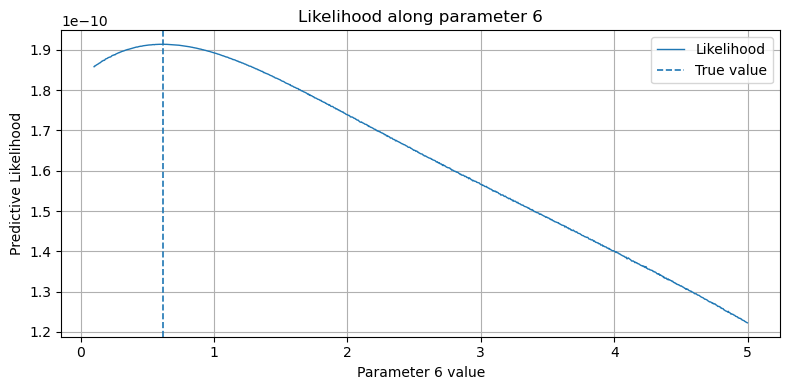

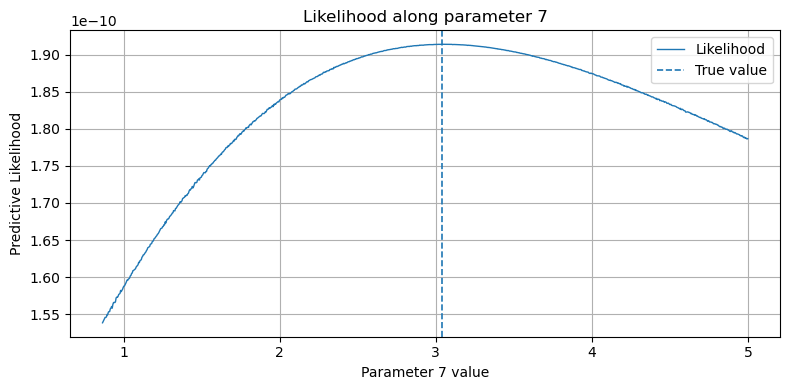

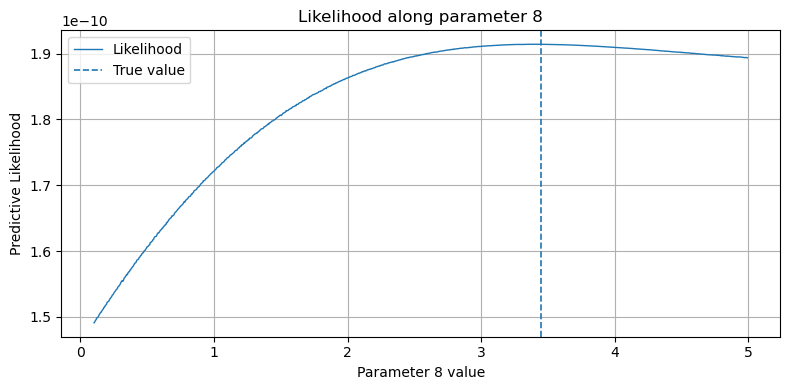

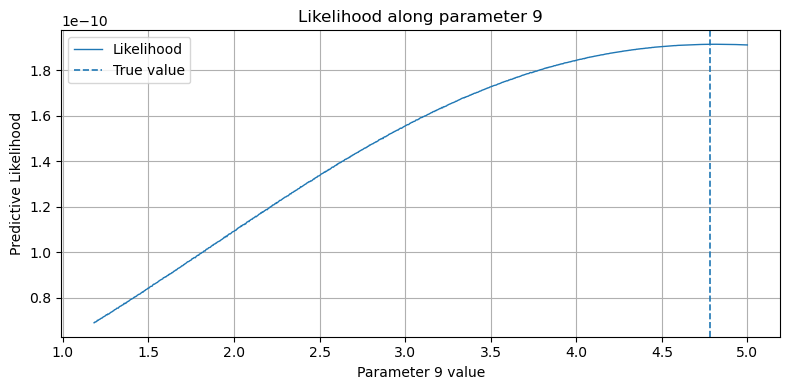

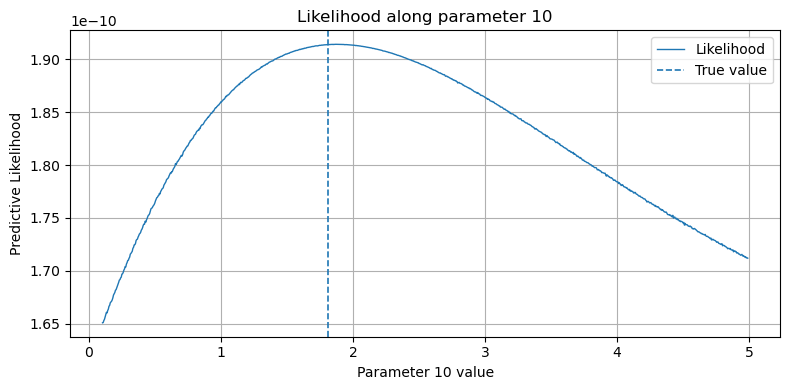

In [7]:
true_theta = test_x[row_idx]

param_bounds = torch.tensor(bound.get_bounds(local_train_x), dtype=torch.float32)

num_points = 1000

model, likelihood = MultitaskGP_models, MultitaskGP_likelihoods

model.eval()
likelihood.eval()


for j in range(true_theta.numel()):
    sweep_vals   = torch.linspace(param_bounds[j,0], param_bounds[j,1], num_points)
    like_traj    = []

    with torch.no_grad():
        for v in sweep_vals:
            theta = true_theta.clone()
            theta[j] = v
            theta_ = theta.unsqueeze(0)

            y_pred_dist = Prediction.preds_distribution_fast_pred_var(
                model, likelihood, theta_
            )
            y_obs = test_y_21[row_idx]
            ll = torch.exp(y_pred_dist.log_prob(y_obs))
            like_traj.append(ll.item())

    plt.figure(figsize=(8,4))
    plt.plot(sweep_vals, like_traj, lw=1, label='Likelihood')
    plt.axvline(true_theta[j].item(), ls='--', lw=1.2, label='True value')
    plt.xlabel(f'Parameter {j+1} value')
    plt.ylabel('Predictive Likelihood')
    plt.title(f'Likelihood along parameter {j+1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# MVGP

In [8]:
checkpoint = torch.load('multitask_gp_checkpoint_21.pth', map_location=Device)
model_params = checkpoint['model_params']

MVGP_models = GP_models.MultitaskVariationalGP(train_x, train_y_21, 
                                               num_latents=model_params['num_latents'], 
                                               num_inducing=model_params['num_inducing'], 
                                               covar_type=model_params['covar_type']).to(Device)

MVGP_models.load_state_dict(checkpoint['model_state_dict'])

MVGP_likelihoods = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=train_y_21.shape[1]).to(Device)
MVGP_likelihoods.load_state_dict(checkpoint['likelihood_state_dict'])


C:\Users\r4718\AppData\Local\Temp\ipykernel_25596\1952528821.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('multitask_gp_checkpoint_21.pth', ma

<All keys matched successfully>

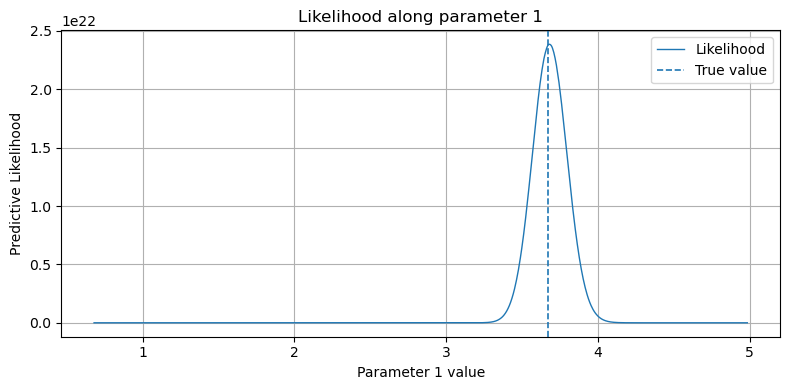

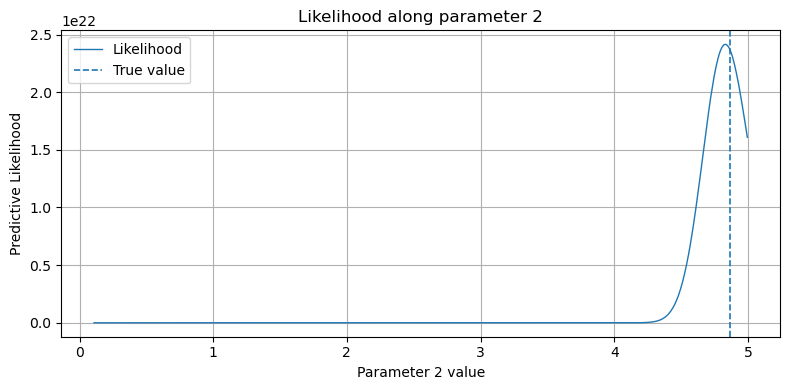

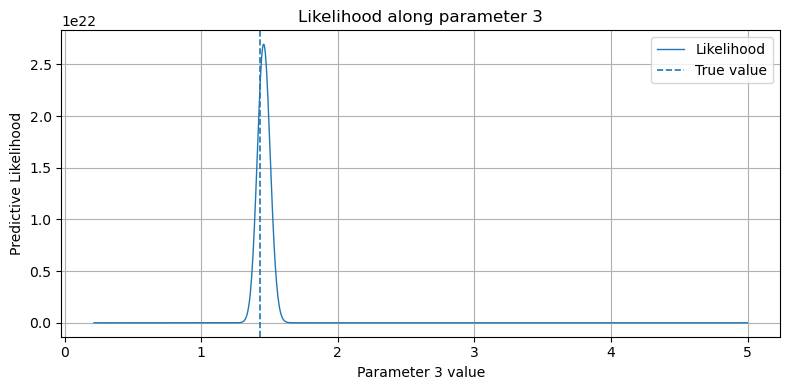

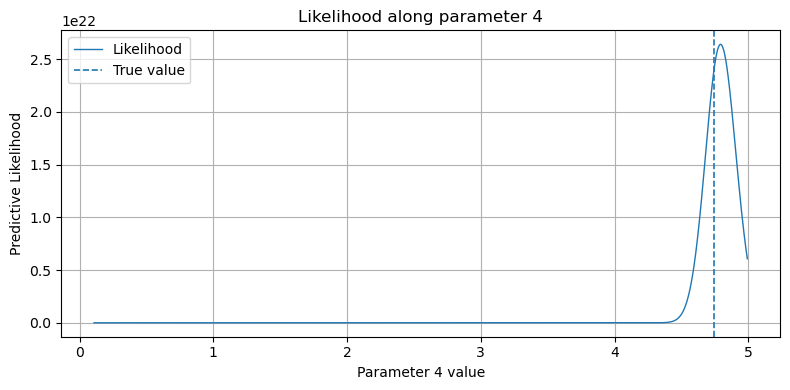

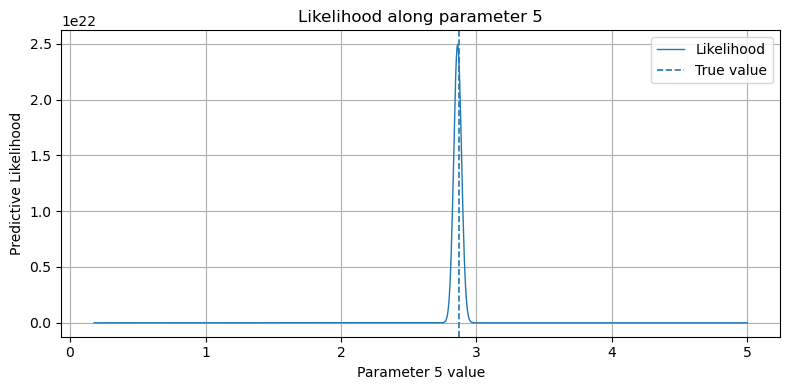

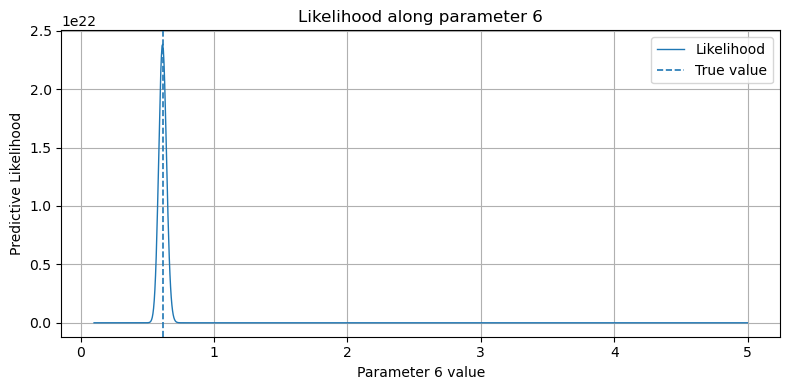

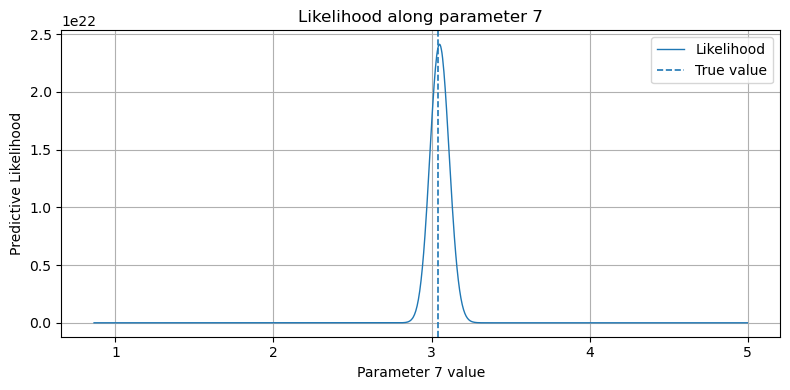

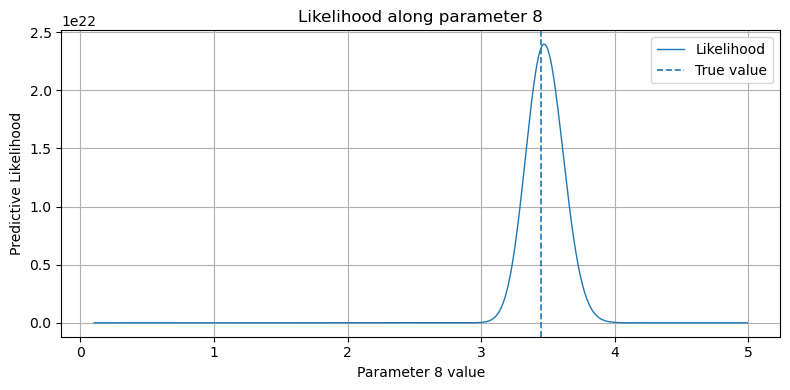

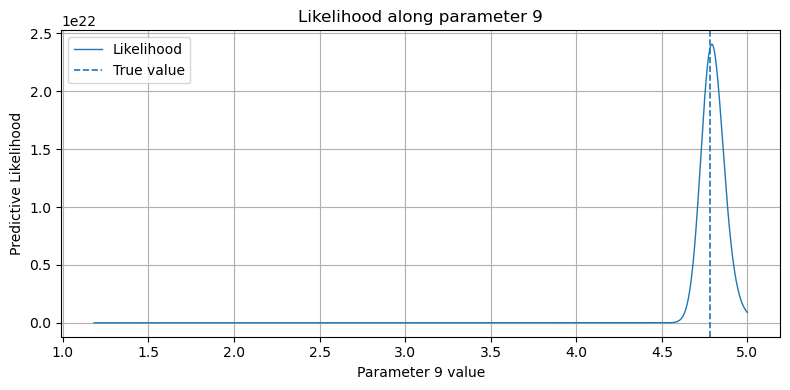

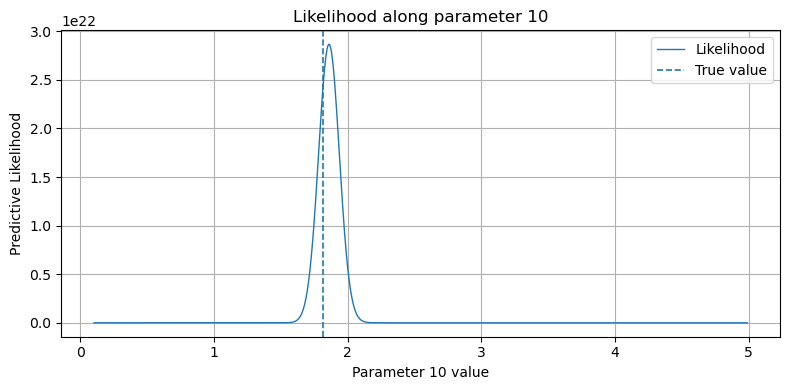

In [9]:
true_theta = test_x[row_idx]

param_bounds = torch.tensor(bound.get_bounds(local_train_x), dtype=torch.float32)

num_points = 1000

model, likelihood = MVGP_models, MVGP_likelihoods

model.eval()
likelihood.eval()


for j in range(true_theta.numel()):
    sweep_vals   = torch.linspace(param_bounds[j,0], param_bounds[j,1], num_points)
    like_traj    = []

    with torch.no_grad():
        for v in sweep_vals:
            theta = true_theta.clone()
            theta[j] = v
            theta_ = theta.unsqueeze(0)

            y_pred_dist = Prediction.preds_distribution_fast_pred_var(
                model, likelihood, theta_
            )
            y_obs = test_y_21[row_idx]
            ll = torch.exp(y_pred_dist.log_prob(y_obs))
            like_traj.append(ll.item())

    plt.figure(figsize=(8,4))
    plt.plot(sweep_vals, like_traj, lw=1, label='Likelihood')
    plt.axvline(true_theta[j].item(), ls='--', lw=1.2, label='True value')
    plt.xlabel(f'Parameter {j+1} value')
    plt.ylabel('Predictive Likelihood')
    plt.title(f'Likelihood along parameter {j+1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# End